# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

In [2]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/larissa/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [3]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

# Create Reinforcement Learning Environment

In [4]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environoments
    visualization::Bool # visualization
    realtime::Bool # realtime
    
    # Everything you need aditionaly can also go in here.
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    ω_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    Δt::T # Δ time
    
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T
end

In [5]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            # orientate yourself on the state space from the paper
            typemin(T)..typemax(T), # position along x
            typemin(T)..typemax(T), # position along z
            
            typemin(T)..typemax(T), # orientation along x
            typemin(T)..typemax(T), # orientation along z
            
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates
            
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # position error along x (next gate - current position)
            typemin(T)..typemax(T), # position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # way to next next gate z (next next gate - next gate)
            # TODO: more points?
            ], 
    )
    
    num_waypoints = 5 # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints) # trajectory with num_waypoints waypoints (+ start point) 
    reached_goal = falses(num_waypoints)
    
    if visualization #visualizes VTOL and waypoints
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
        visualize_waypoints(waypoints, 0.15)
    end

    environment = VtolEnv(
        action_space,
        state_space, 
        zeros(T, length(state_space)), # current state, needs to be extended
        rand(action_space), #initialization action
        false, # episode done 
        0.0, # time
        rng, # random number generator  
        
        name,
        visualization,
        realtime,
        
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation, Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt 
        
        num_waypoints, # includig start point
        waypoints, 
        reached_goal,
        
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        0.5 # r_tol
    )
    
    
    reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [6]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at In[5]:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, num_waypoints::Int64, waypoints::Array{Vector{T}, 1}, reached_goal::BitVector, progress::T, progress_prev::T, current_point::Int64, reached_goal_in_step::Bool, r_tol::T) where {A, T, ACT, R<:AbstractRNG} in Main at In[4]:2

# Define the RL interface

In [7]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [8]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    norm_way = 0.0 # DEBUG: save in environment
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    v_min = 1.0 # min velocity
    v_max = 3.0 # max velocity
    
    k_wp = 5.0 # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate, TODO: change to gates later (when gates != waypoints)
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end
    
    k_ω = 0.01 # factor for too high body rate penalty
    norm_ω = norm(env.ω_B[3]) # penalty for body rate 

    k_s = 2.0 / norm_way #5.0 # factor for reached distance (overall) reward, TODO later add factor as in paper (p. 4)
    r_s = env.progress # reward for reached distance (overall)
    
    k_p = 5.0 / norm_way;# factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    return k_p * r_p + k_s * k_s + k_wp * r_wp - k_ω * norm_ω
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [9]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));

    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];
    
    env.num_waypoints = 5; # includig start point
    env.waypoints = generate_trajectory(env.num_waypoints);
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    env.r_tol = 0.5;
    
    if env.visualization
        visualize_waypoints(env.waypoints, 0.15); # debug: other radius?
    end
    

    env.progress = 0.0;
    env.progress_prev = 0.0;
    
    
    env.state = [env.x_W[1]; # position along x
                 env.x_W[3]; # position along z
        
                 env.R_W[1,1]; # orientation along x
                 env.R_W[3,1]; # orientation along z
        
                 env.v_B[1]; # velocity along x BODY coordinates
                 env.v_B[2]; # velocity along y BODY coordinates  
        
                 env.ω_B[3]; # rotational velocity along z BODY coordinates
        
                 env.waypoints[2][1] - env.x_W[1]; # position error along x
                 env.waypoints[2][3] - env.x_W[3]; # position error along z
                 
                 0.0; # way to next next gate x (next next gate - next gate)
                 0.0] # way to next next gate z (next next gate - next gate)
    
    if env.num_waypoints >= 3
        env.state[10] = env.waypoints[3][1] - env.waypoints[2][1]; # way to next next gate x (next next gate - next gate)
        env.state[11] = env.waypoints[3][3] - env.waypoints[2][1]; # way to next next gate z (next next gate - next gate)
    end
        
    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;
    
    nothing

end;

In [10]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # TODO: set flaps later in 3D
    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[2], 0.0, 0.0]
   
    _step!(env, next_action)
end

In [11]:
env = VtolEnv();

In [12]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at In[10]:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [13]:
function _step!(env::VtolEnv, next_action)
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0; torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0; env.ω_B[2] = 0.0;
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)
    
    
    
    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
        
        
        
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, progress = calculate_progress(env.waypoints, env.x_W)
    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - progress)
    
    env.progress = current_progress
    
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state 
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
        
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.2, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end
    end
 
    env.t += env.Δt

    
    
    env.state[1] = env.x_W[1]; # position along x
    env.state[2] = env.x_W[3]; # position along z
    
    env.state[3] = env.R_W[1,1]; # orientation along x
    env.state[4] = env.R_W[3,1]; # orientation along z
    
    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates
    
    env.state[7] = env.ω_B[3];  # rotational velocity along z BODY coordinates
    
    
    if env.current_point <= env.num_waypoints
        env.state[8] = env.waypoints[env.current_point][1] - env.x_W[1]; # position error along x
        env.state[9] = env.waypoints[env.current_point][3] - env.x_W[3]; # position error along z
        
        if env.current_point <= env.num_waypoints - 1
            env.state[10] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1]; # way to next next gate x (next next gate - next gate)
            env.state[11] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # way to next next gate z (next next gate - next gate)
        else
            env.state[10] = 0.0 # way to next next gate x (next next gate - next gate)
            env.state[11] = 0.0 # way to next next gate z (next next gate - next gate)
        end
    else
        env.state[8] = 0.0; # position error along x
        env.state[9] = 0.0; # position error along z
        env.state[10] = 0.0 # way to next next gate x (next next gate - next gate)
        env.state[11] = 0.0 # way to next next gate z (next next gate - next gate)
    end
        
    
    # Termination criteria
    # TODO: Use many termination criteria so that you do not train unnecessarily in wrong areas
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 100.0 || 
        norm(env.v_B) > 100.0 || # stop if body is too fast # TODO: set higher later in fast training phase
        env.x_W[3] < -5.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 5.0 ||# stop after 5s per point
        norm(env.x_W - progress) > 2.0 || # too far off the path
        env.current_point > env.num_waypoints # all points reached
    nothing
end;

In [14]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  2.4s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.670497150569654e9, 1.670497152946191e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [15]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ])

MultiThreadEnv(8 x VtolEnv)

In [16]:
# Define the function approximator
# TODO: change architecture eventually 
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 256, relu; initW = glorot_uniform(rng)),#
                    Dense(256, 256, relu; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(256, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(256, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 256, relu; initW = glorot_uniform(rng)),
                    Dense(256, 256, relu; initW = glorot_uniform(rng)),
                    Dense(256, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

In [17]:
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # TODO: change eventually
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /home/larissa/.julia/packages/Flux/7nTyc/src/functor.jl:187


In [18]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./RL_models_l/", "vtol_2D_ppo_$t.bson") # TODO: evtl anpassen
    @save f model
    println("parameters at step $t saved to $f")
end;

In [19]:
function loadModel()
    f = joinpath("./RL_models_l/", "vtol_2D_ppo_trained_on_random_point.bson") # TODO: evtl anpassen
    @load f model
    return model
end;

In [20]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")
    
end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

In [21]:
agent.policy.approximator = loadModel(); # TODO: un/comment

In [22]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000), 
        DoEveryNStep(validate_policy, n=10_000)),
)

Progress:   1%|▎                                        |  ETA: 3:25:1039m

test reward at step 10000: 1.6122013130545758


Progress:   1%|▌                                        |  ETA: 1:57:23

test reward at step 20000: 3.250199400139729


Progress:   2%|▉                                        |  ETA: 1:25:41

test reward at step 30000: 2.984362395344463


Progress:   3%|█▏                                       |  ETA: 1:12:16

test reward at step 40000: 3.2333137677109662


Progress:   3%|█▍                                       |  ETA: 1:02:22

test reward at step 50000: 3.1684648484696845


Progress:   4%|█▋                                       |  ETA: 0:56:29

test reward at step 60000: 0.4500351374031978


Progress:   5%|█▉                                       |  ETA: 0:52:27

test reward at step 70000: 3.8598492514475677


Progress:   5%|██▏                                      |  ETA: 0:48:59

test reward at step 80000: 5.309506628462498


Progress:   6%|██▌                                      |  ETA: 0:46:50

test reward at step 90000: 6.370279276635561


Progress:   7%|██▊                                      |  ETA: 0:44:52

parameters at step 100000 saved to ./RL_models_l/vtol_2D_ppo_100000.bson
test reward at step 100000: 4.417499247772425


Progress:   7%|███                                      |  ETA: 0:44:00

test reward at step 110000: 4.203921235468894


Progress:   8%|███▎                                     |  ETA: 0:42:24

test reward at step 120000: 3.888152844320259


Progress:   9%|███▌                                     |  ETA: 0:40:58

test reward at step 130000: 10.116623841508307


Progress:   9%|███▊                                     |  ETA: 0:40:12

test reward at step 140000: 2.134488427962339


Progress:  10%|████                                     |  ETA: 0:39:19

test reward at step 150000: 3.9915429662850346


Progress:  11%|████▍                                    |  ETA: 0:38:03

test reward at step 160000: 5.376609611027936


Progress:  11%|████▋                                    |  ETA: 0:37:20

test reward at step 170000: 4.311137210142739


Progress:  12%|████▉                                    |  ETA: 0:36:34

test reward at step 180000: 7.104834806500221


Progress:  13%|█████▏                                   |  ETA: 0:35:46

test reward at step 190000: 4.290680778906242


Progress:  13%|█████▌                                   |  ETA: 0:34:47

parameters at step 200000 saved to ./RL_models_l/vtol_2D_ppo_200000.bson
test reward at step 200000: 3.8439255576572005


Progress:  14%|█████▋                                   |  ETA: 0:34:11

test reward at step 210000: 4.717985929805074


Progress:  15%|██████                                   |  ETA: 0:33:29

test reward at step 220000: 6.431571465652422


Progress:  15%|██████▎                                  |  ETA: 0:32:55

test reward at step 230000: 3.6813753811204712


Progress:  16%|██████▌                                  |  ETA: 0:32:20

test reward at step 240000: 4.866455666830438


Progress:  17%|██████▊                                  |  ETA: 0:32:04

test reward at step 250000: 4.003138574853956


Progress:  17%|███████▏                                 |  ETA: 0:31:19

test reward at step 260000: 5.142419563696955


Progress:  18%|███████▍                                 |  ETA: 0:30:55

test reward at step 270000: 7.002971405968598


Progress:  19%|███████▋                                 |  ETA: 0:30:34

test reward at step 280000: 4.24788853876331


Progress:  19%|███████▉                                 |  ETA: 0:30:00

test reward at step 290000: 5.500895814675606


Progress:  20%|████████▏                                |  ETA: 0:29:34

parameters at step 300000 saved to ./RL_models_l/vtol_2D_ppo_300000.bson
test reward at step 300000: 4.23625252539779


Progress:  21%|████████▌                                |  ETA: 0:29:12

test reward at step 310000: 3.878802579512271


Progress:  21%|████████▊                                |  ETA: 0:28:48

test reward at step 320000: 14.098754311666404


Progress:  22%|█████████                                |  ETA: 0:28:27

test reward at step 330000: 6.880077474327202


Progress:  23%|█████████▎                               |  ETA: 0:28:07

test reward at step 340000: 4.427485138047936


Progress:  23%|█████████▌                               |  ETA: 0:27:40

test reward at step 350000: 7.508863020130811


Progress:  24%|█████████▉                               |  ETA: 0:27:18

test reward at step 360000: 9.40794029238406


Progress:  25%|██████████▏                              |  ETA: 0:27:01

test reward at step 370000: 5.1939526506910365


Progress:  25%|██████████▍                              |  ETA: 0:26:46

test reward at step 380000: 5.414069911126518


Progress:  26%|██████████▋                              |  ETA: 0:26:19

test reward at step 390000: 7.309433870733702


Progress:  27%|██████████▉                              |  ETA: 0:26:00

parameters at step 400000 saved to ./RL_models_l/vtol_2D_ppo_400000.bson
test reward at step 400000: 9.789392021401426


Progress:  27%|███████████▎                             |  ETA: 0:25:41

test reward at step 410000: 3.7160639854502997


Progress:  28%|███████████▌                             |  ETA: 0:25:25

test reward at step 420000: 1.1743157126971533


Progress:  29%|███████████▊                             |  ETA: 0:25:00

test reward at step 430000: 11.890975569356733


Progress:  29%|████████████                             |  ETA: 0:24:43

test reward at step 440000: 5.047396561094631


Progress:  30%|████████████▎                            |  ETA: 0:24:28

test reward at step 450000: 6.121674958427411


Progress:  31%|████████████▌                            |  ETA: 0:24:07

test reward at step 460000: 3.8262622853768296


Progress:  31%|████████████▉                            |  ETA: 0:23:48

test reward at step 470000: 5.963286156505176


Progress:  32%|█████████████▏                           |  ETA: 0:23:38

test reward at step 480000: 11.266108701134888


Progress:  33%|█████████████▍                           |  ETA: 0:23:18

test reward at step 490000: 2.741601539527961


Progress:  33%|█████████████▋                           |  ETA: 0:23:02

parameters at step 500000 saved to ./RL_models_l/vtol_2D_ppo_500000.bson
test reward at step 500000: 8.182316622502501


Progress:  34%|█████████████▉                           |  ETA: 0:22:46

test reward at step 510000: 7.72274552575857


Progress:  35%|██████████████▎                          |  ETA: 0:22:30

test reward at step 520000: 4.735405928554925


Progress:  35%|██████████████▌                          |  ETA: 0:22:19

test reward at step 530000: 5.678873161230303


Progress:  36%|██████████████▊                          |  ETA: 0:22:04

test reward at step 540000: 7.897007197405156


Progress:  37%|███████████████                          |  ETA: 0:21:43

test reward at step 550000: 7.8444800872678035


Progress:  37%|███████████████▎                         |  ETA: 0:21:30

test reward at step 560000: 11.537449951006737


Progress:  38%|███████████████▌                         |  ETA: 0:21:13

test reward at step 570000: 6.448858050992304


Progress:  39%|███████████████▉                         |  ETA: 0:20:57

test reward at step 580000: 8.26871175341877


Progress:  39%|████████████████▏                        |  ETA: 0:20:40

test reward at step 590000: 6.266425072413767


Progress:  40%|████████████████▍                        |  ETA: 0:20:25

parameters at step 600000 saved to ./RL_models_l/vtol_2D_ppo_600000.bson
test reward at step 600000: 7.877919570687313


Progress:  40%|████████████████▋                        |  ETA: 0:20:14

test reward at step 610000: 7.528519369673256


Progress:  41%|█████████████████                        |  ETA: 0:19:53

test reward at step 620000: 7.231579111833894


Progress:  42%|█████████████████▎                       |  ETA: 0:19:39

test reward at step 630000: 4.2361869529377145


Progress:  43%|█████████████████▌                       |  ETA: 0:19:26

test reward at step 640000: 4.9572403763965


Progress:  43%|█████████████████▊                       |  ETA: 0:19:12

test reward at step 650000: 8.429867204128072


Progress:  44%|██████████████████                       |  ETA: 0:18:55

test reward at step 660000: 4.485087796718754


Progress:  45%|██████████████████▎                      |  ETA: 0:18:39

test reward at step 670000: 0.4600125929449985


Progress:  45%|██████████████████▌                      |  ETA: 0:18:28

test reward at step 680000: 6.822807202269242


Progress:  46%|██████████████████▊                      |  ETA: 0:18:10

test reward at step 690000: 0.14406788547534655


Progress:  47%|███████████████████▏                     |  ETA: 0:17:51

parameters at step 700000 saved to ./RL_models_l/vtol_2D_ppo_700000.bson
test reward at step 700000: 6.34870140894529


Progress:  47%|███████████████████▍                     |  ETA: 0:17:36

test reward at step 710000: 7.3824833342770315


Progress:  48%|███████████████████▋                     |  ETA: 0:17:23

test reward at step 720000: 3.095734928657479


Progress:  49%|███████████████████▉                     |  ETA: 0:17:08

test reward at step 730000: 3.580663502037405


Progress:  49%|████████████████████▎                    |  ETA: 0:16:53

test reward at step 740000: 6.001842880741668


Progress:  50%|████████████████████▌                    |  ETA: 0:16:37

test reward at step 750000: 3.3703484052952164


Progress:  51%|████████████████████▊                    |  ETA: 0:16:24

test reward at step 760000: 8.788005888541402


Progress:  51%|█████████████████████                    |  ETA: 0:16:10

test reward at step 770000: 6.546742155943628


Progress:  52%|█████████████████████▎                   |  ETA: 0:15:55

test reward at step 780000: 5.938248438016893


Progress:  53%|█████████████████████▋                   |  ETA: 0:15:41

test reward at step 790000: 1.051095783284805


Progress:  53%|█████████████████████▉                   |  ETA: 0:15:28

parameters at step 800000 saved to ./RL_models_l/vtol_2D_ppo_800000.bson
test reward at step 800000: 7.560651474416542


Progress:  54%|██████████████████████▏                  |  ETA: 0:15:13

test reward at step 810000: 7.770663682776545


Progress:  55%|██████████████████████▍                  |  ETA: 0:15:00

test reward at step 820000: 5.999602941084145


Progress:  55%|██████████████████████▋                  |  ETA: 0:14:46

test reward at step 830000: 7.226806789576442


Progress:  56%|███████████████████████                  |  ETA: 0:14:33

test reward at step 840000: 7.598912492852468


Progress:  57%|███████████████████████▎                 |  ETA: 0:14:19

test reward at step 850000: 6.55827715560009


Progress:  57%|███████████████████████▌                 |  ETA: 0:14:05

test reward at step 860000: 3.996999783664063


Progress:  58%|███████████████████████▊                 |  ETA: 0:13:55

test reward at step 870000: 4.001564729207316


Progress:  59%|████████████████████████                 |  ETA: 0:13:38

test reward at step 880000: 6.277315534936281


Progress:  59%|████████████████████████▎                |  ETA: 0:13:26

test reward at step 890000: 6.1230084608414765


Progress:  60%|████████████████████████▌                |  ETA: 0:13:13

parameters at step 900000 saved to ./RL_models_l/vtol_2D_ppo_900000.bson
test reward at step 900000: 6.058083046211649


Progress:  61%|████████████████████████▉                |  ETA: 0:12:58

test reward at step 910000: 7.694240449899305


Progress:  61%|█████████████████████████▏               |  ETA: 0:12:44

test reward at step 920000: 7.722259639800522


Progress:  62%|█████████████████████████▍               |  ETA: 0:12:31

test reward at step 930000: 5.941116879162933


Progress:  63%|█████████████████████████▋               |  ETA: 0:12:20

test reward at step 940000: 4.36729238744188


Progress:  63%|██████████████████████████               |  ETA: 0:12:04

test reward at step 950000: 2.682259924563527


Progress:  64%|██████████████████████████▎              |  ETA: 0:11:52

test reward at step 960000: 8.805269379115078


Progress:  65%|██████████████████████████▌              |  ETA: 0:11:37

test reward at step 970000: 3.1175322998912165


Progress:  65%|██████████████████████████▊              |  ETA: 0:11:26

test reward at step 980000: 5.196968849532756


Progress:  66%|███████████████████████████              |  ETA: 0:11:10

test reward at step 990000: 7.53722296405868


Progress:  67%|███████████████████████████▎             |  ETA: 0:10:59

parameters at step 1000000 saved to ./RL_models_l/vtol_2D_ppo_1000000.bson
test reward at step 1000000: 3.392330045818229


Progress:  67%|███████████████████████████▌             |  ETA: 0:10:46

test reward at step 1010000: 5.991668587578807


Progress:  68%|███████████████████████████▉             |  ETA: 0:10:31

test reward at step 1020000: 6.495130481457065


Progress:  69%|████████████████████████████▏            |  ETA: 0:10:19

test reward at step 1030000: 2.8588245309568645


Progress:  69%|████████████████████████████▍            |  ETA: 0:10:05

test reward at step 1040000: 1.4144951605338019


Progress:  70%|████████████████████████████▋            |  ETA: 0:09:52

test reward at step 1050000: 7.109925324702615


Progress:  71%|█████████████████████████████            |  ETA: 0:09:38

test reward at step 1060000: 6.152266556674517


Progress:  71%|█████████████████████████████▎           |  ETA: 0:09:25

test reward at step 1070000: 6.449803657759435


Progress:  72%|█████████████████████████████▌           |  ETA: 0:09:09

test reward at step 1080000: 6.828127401139752


Progress:  73%|█████████████████████████████▊           |  ETA: 0:08:57

test reward at step 1090000: 7.93062100908047


Progress:  73%|██████████████████████████████▏          |  ETA: 0:08:43

parameters at step 1100000 saved to ./RL_models_l/vtol_2D_ppo_1100000.bson
test reward at step 1100000: 11.231078976329085


Progress:  74%|██████████████████████████████▎          |  ETA: 0:08:32

test reward at step 1110000: 4.357426090806025


Progress:  75%|██████████████████████████████▋          |  ETA: 0:08:17

test reward at step 1120000: 6.100966126512037


Progress:  75%|██████████████████████████████▉          |  ETA: 0:08:03

test reward at step 1130000: 6.791747592654281


Progress:  76%|███████████████████████████████▏         |  ETA: 0:07:53

test reward at step 1140000: 3.44110015939955


Progress:  77%|███████████████████████████████▍         |  ETA: 0:07:37

test reward at step 1150000: 7.243684232194053


Progress:  77%|███████████████████████████████▊         |  ETA: 0:07:24

test reward at step 1160000: 10.487722369466901


Progress:  78%|███████████████████████████████▉         |  ETA: 0:07:14

test reward at step 1170000: 3.8712464965421836


Progress:  79%|████████████████████████████████▎        |  ETA: 0:06:59

test reward at step 1180000: 5.984923195338258


Progress:  79%|████████████████████████████████▌        |  ETA: 0:06:44

test reward at step 1190000: 6.439496033286499


Progress:  80%|████████████████████████████████▊        |  ETA: 0:06:31

parameters at step 1200000 saved to ./RL_models_l/vtol_2D_ppo_1200000.bson
test reward at step 1200000: 3.4011398220952986


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:06:18

test reward at step 1210000: 3.324394614968403


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:06:05

test reward at step 1220000: 3.307652759693899


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:05:53

test reward at step 1230000: 2.942545431236538


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:05:40

test reward at step 1240000: -0.7426480904082563


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:05:27

test reward at step 1250000: 3.7455984418833066


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:05:13

test reward at step 1260000: 2.8824949356249276


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:05:00

test reward at step 1270000: 2.243743384974893


Progress:  85%|███████████████████████████████████      |  ETA: 0:04:47

test reward at step 1280000: 3.587378029055515


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:04:34

test reward at step 1290000: 1.3751280193398734


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:04:21

parameters at step 1300000 saved to ./RL_models_l/vtol_2D_ppo_1300000.bson
test reward at step 1300000: 6.093949976563123


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:04:09

test reward at step 1310000: 6.07560197693965


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:03:54

test reward at step 1320000: 5.684643928839413


Progress:  89%|████████████████████████████████████▍    |  ETA: 0:03:42

test reward at step 1330000: 4.638506996680934


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:03:30

test reward at step 1340000: 3.6366400920129167


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:03:15

test reward at step 1350000: 3.9896910014266695


Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:03:02

test reward at step 1360000: 5.3026992931372305


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:02:50

test reward at step 1370000: 1.3127794590228528


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:02:37

test reward at step 1380000: 2.8671375231855696


Progress:  93%|██████████████████████████████████████   |  ETA: 0:02:23

test reward at step 1390000: 6.738469305917777


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:02:10

parameters at step 1400000 saved to ./RL_models_l/vtol_2D_ppo_1400000.bson
test reward at step 1400000: 2.822703914725651


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:01:57

test reward at step 1410000: 6.160013586863542


Progress:  95%|██████████████████████████████████████▊  |  ETA: 0:01:44

test reward at step 1420000: 3.122011550685164


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:01:32

test reward at step 1430000: -1.0172797681165953


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:01:21

test reward at step 1440000: 0.9916879649462638


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:01:06

test reward at step 1450000: -1.148689370485036


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:53

test reward at step 1460000: 3.38353351497791


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:39

test reward at step 1470000: 6.918591569124934


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:26

test reward at step 1480000: 3.440523149287551


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:13

test reward at step 1490000: 4.205522053640606


Progress: 100%|█████████████████████████████████████████| Time: 0:32:16


parameters at step 1500000 saved to ./RL_models_l/vtol_2D_ppo_1500000.bson
test reward at step 1500000: 6.246234533003464


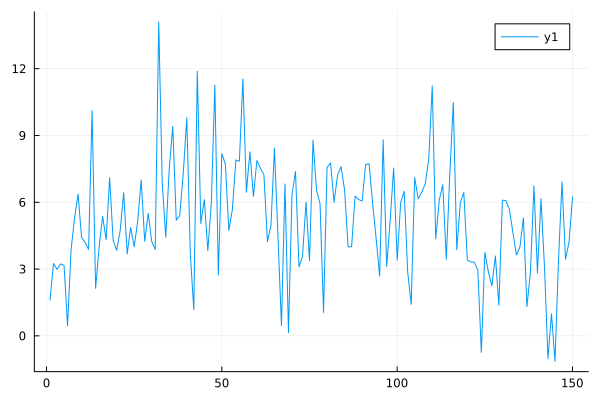

In [23]:
plot(episode_test_reward_hook.rewards)

In [24]:
close_visualization(); # closes the MeshCat visualization